# SAR ADC

In [1]:
class SAR:
    def __init__(self, bit, ncomp, ndac, nsamp, radix):
        self.ncomp = ncomp
        self.ndac = ndac
        self.nsamp = nsamp
        self.bit = bit
        self.radix = radix
        self.cdac = self.dac()
    
    def comp(self, compin):
        #note that comparator output suffers from noise of comp and dac
        comptemp = compin + np.random.randn(compin.shape[0])*self.ncomp + np.random.randn(compin.shape[0])*self.ndac
        
        #comp function in vectors
        out = np.maximum(comptemp*10E6, -1)
        out = np.minimum(out, 1)
        return(out)
    
    def dac(self):
        cdac = np.zeros((self.bit,1))
        for i in range(self.bit):
            cdac[i] = np.power(self.radix,(self.bit-1-i))
        cdac = cdac/(sum(cdac)+1) #normalize to full scale = 1
        #mismatches are tbd
        return(cdac)

    def sarloop(self, adcin):
        #add sampling noise to input first
        adcin += np.random.randn(adcin.shape[0]) * self.nsamp
        adcout = np.zeros_like(adcin)
        
        #loop for sar cycles
        for cyloop in range(self.bit):
            compout = self.comp(adcin)
            adcin += compout * (-1) * self.cdac[cyloop] #update cdac output
            adcout += np.power(self.radix, self.bit-1-cyloop)*np.maximum(compout, 0)
            #print(cyloop)
        return(adcout)

def normalize_input(inp):
    center = np.mean(inp)
    out = inp - center
    
    maxbin = np.max(out) * 2
    out = out / maxbin
    
    return out, center, maxbin

# Generate Signal

In [58]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt


# データのパラメータ
N = 4096
fs = 1.6*1e9
dt = 1/fs
f1 = fs/N*250    # 周波数
print(f1/1e9)
t = np.arange(0, N*dt, dt) # 時間軸
freq = np.linspace(0, 1, N)*fs # 周波数軸

0.09765625


In [59]:
# offset
offset = 1/(2^12)

# 信号を生成
input = np.sin(2*np.pi*f1*t) #+ 0.001 * np.random.randn(N)

In [60]:
# ADCを宣言
adc = SAR(10, 1e-5, 0, 0, 2)

# 量子化を実施
adcout = adc.sarloop(input)

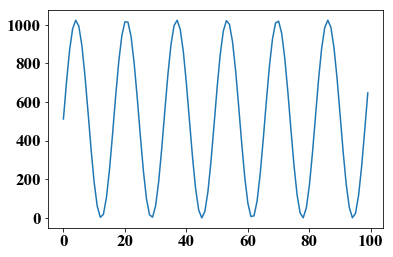

In [61]:
plt.plot(adcout[:100])

In [62]:
# 高速フーリエ変換
F = np.fft.fft(adcout)

# 振幅スペクトルを計算
Amp = np.power(np.abs(F)[0:int(N/2)-1], 2)
Amp[0] = 0 # cut DC
freq = freq[0:int(N/2)-1]
print("freq:", freq.shape)
print("Amp:", Amp.shape)
#Amp = np.abs(F)
#freq = freq

# 正規化
Amp /= max(Amp)

freq: (2047,)
Amp: (2047,)


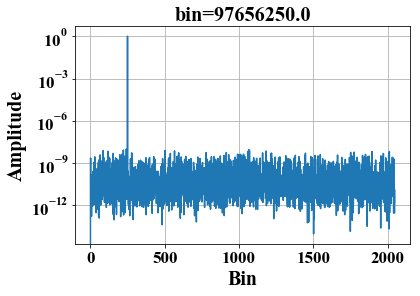

In [63]:
# グラフ表示
plt.figure()
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 17

plt.title("bin={}".format(f1))
plt.plot(Amp, label='|F(k)|')
plt.xlabel('Bin', fontsize=20)
plt.ylabel('Amplitude', fontsize=20)
plt.yscale('log')
plt.grid()
#leg = plt.legend(loc=1, fontsize=25)
#leg.get_frame().set_alpha(1)
plt.show()

# +clk skew 2channels

freq: (2047,)
Amp: (2047,)


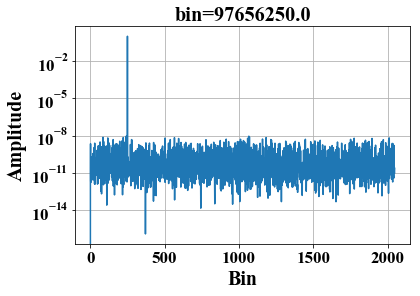

SNR: [61.99183039]
ENOB: [10.00528744]
freq: (2047,)
Amp: (2047,)


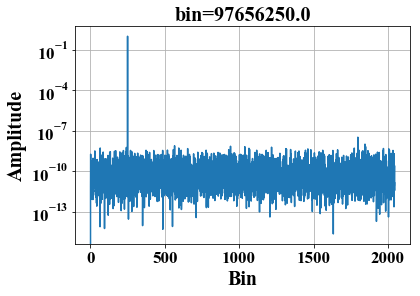

SNR: [61.82879579]
ENOB: [9.97820528]
freq: (2047,)
Amp: (2047,)


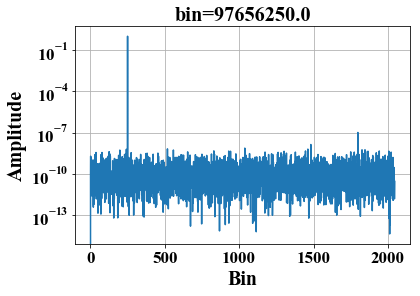

SNR: [61.4294345]
ENOB: [9.9118662]
freq: (2047,)
Amp: (2047,)


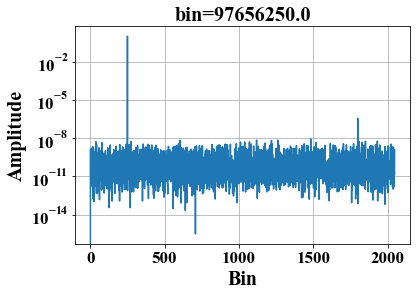

SNR: [60.08470914]
ENOB: [9.68848989]
freq: (2047,)
Amp: (2047,)


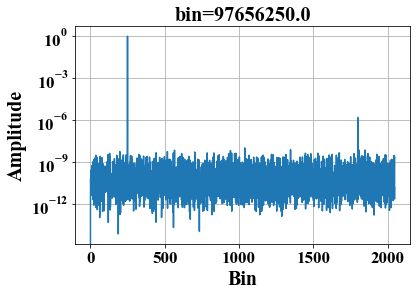

SNR: [56.53227987]
ENOB: [9.09838536]
freq: (2047,)
Amp: (2047,)


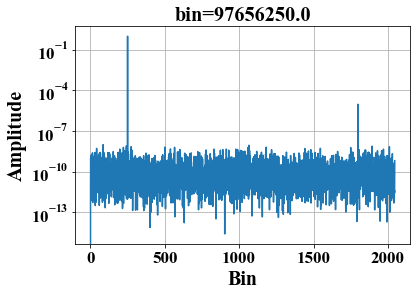

SNR: [49.97406796]
ENOB: [8.00898139]


In [67]:
# 信号を生成
skew = 1.5e-12
skews = [0, 0.5e-12, 1e-12, 2e-12, 4e-12, 10e-12]
enobs = []
for skew in skews:
    input1 = np.sin(2*np.pi*f1*t)
    input2 = np.sin(2*np.pi*f1*(t+skew))
    input = []
    for i in range(N):
        if i%2==0:
            input.append(input1[i])
        else:
            input.append(input2[i])
            
    input = np.array(input)
    # 量子化を実施
    adcout = adc.sarloop(input)
    # 高速フーリエ変換
    F = np.fft.fft(adcout)

    # 振幅スペクトルを計算
    Amp = np.power(np.abs(F)[0:int(N/2)-1], 2)
    Amp[0] = 0 # cut DC
    freq = freq[0:int(N/2)-1]
    #Amp = np.abs(F)
    #freq = freq

    # 正規化
    Amp /= max(Amp)
    print("freq:", freq.shape)
    print("Amp:", Amp.shape)
    # グラフ表示
    plt.figure()
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = 17

    plt.title("bin={}".format(f1))
    plt.plot(Amp, label='|F(k)|')
    plt.xlabel('Bin', fontsize=20)
    plt.ylabel('Amplitude', fontsize=20)
    plt.yscale('log')
    plt.grid()
    #leg = plt.legend(loc=1, fontsize=25)
    #leg.get_frame().set_alpha(1)
    plt.show()
    # SNR計算
    sig_bin = np.where(Amp==np.abs(Amp).max())[0]
    signal_power = Amp[sig_bin]

    noise_power = Amp.sum() - signal_power

    SNR = signal_power / noise_power
    SNR = 10*np.log10(SNR)

    ENOB = (SNR-1.76) / 6.02
    print("SNR:", SNR)
    print("ENOB:", ENOB)
    enobs.append(ENOB)

Text(0.5, 1.0, 'skew effect for 10b 1.6GHz ADC, 100MHz input')

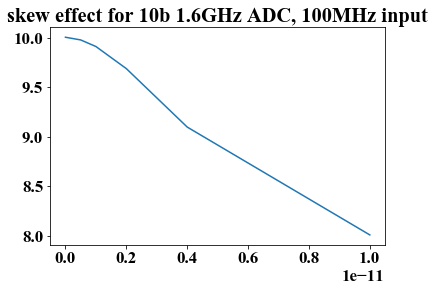

In [68]:
plt.plot(skews, enobs)
plt.title("skew effect for 10b 1.6GHz ADC, 100MHz input")